# Main Program for DNN with Dropout

Main program to train the leaf temperature parameter.

Author: Efraim Manurung

MSc Thesis in Information Technology Group, Wageningen University

efraim.manurung@gmail.com

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
import joblib

import seaborn as sns

In [8]:
import pandas as pd

# Load the datasets from separate files
file_path = r"iot-datasets-train-dnn-leaf.xlsx"

# Load and clean the training dataset
mgh_data = pd.read_excel(file_path)

# Display the first few rows of the dataframe
mgh_data.head()



,time,global out,global in,temp in,temp out,rh in,rh out,co2 in,co2 out,ventilation,toplights,heater,leaf temp
0,0,0.026307,1.35090,21.55,23.5,53.30,48.0,400,798,0.0,1.0,0.0,21.5
1,300,0.026307,1.33905,21.65,23.5,52.95,47.8,400,783,0.0,1.0,0.0,21.5
2,600,0.026307,1.33115,21.80,23.3,52.75,48.1,400,768,0.0,1.0,0.0,21.5
3,900,0.026307,1.33115,21.90,23.3,52.15,48.1,400,760,0.0,1.0,0.0,21.5
4,1200,0.026307,1.31930,22.05,23.3,52.20,48.0,400,749,0.0,1.0,0.0,21.5


In [11]:
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

def train_and_evaluate_model(target_variable, flag_train, _epochs=100, _batch_size=10):
    features = ['time', 'global out', 'temp out', 'rh out', 'co2 out', 'ventilation', 'toplights', 'heater']
    
    X = mgh_data[features]
    y = mgh_data[target_variable]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    # Initialize and fit the scaler on the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if flag_train:        
        model = Sequential()
        model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dropout(0.2))  # Dropout after input layer
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))  # Dropout after first hidden layer
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))  # Dropout after second hidden layer
        model.add(Dense(1))
        
        # Adam optimizer
        # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
        '''
        Args
        learning_rate	A float, a keras.optimizers.schedules.LearningRateSchedule instance, 
                        or a callable that takes no arguments and returns the actual value to use. 
                        The learning rate. Defaults to 0.001.
        
        use_ema	Boolean, defaults to False. If True, exponential moving average (EMA) is applied. 
                        EMA consists of computing an exponential moving average of the weights of the model 
                        (as the weight values change after each training batch), and periodically overwriting 
                        the weights with their moving average.
                        
        ema_momentum	Float, defaults to 0.99. Only used if use_ema=True. 
                        This is the momentum to use when computing the EMA of the model's weights: new_average = ema_momentum * old_average + (1 - ema_momentum) * current_variable_value.
        
        The learning rate was lifted by one order of magnitude, and the momentum was increased to 0.9. 
        These increases in the learning rate were also recommended in the original Dropout paper (https://jmlr.org/papers/v15/srivastava14a.html)
        
        '''
        adam = Adam(learning_rate=0.001, use_ema=True, ema_momentum=0.9)
        
        # changed adam compare to rmsprop
        model.compile(optimizer=adam, 
                      loss='mean_squared_error', 
                      metrics=['mae', r2_score_metric])

        history = model.fit(X_train_scaled, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)
        
        # Save the model in the recommended Keras format
        model.save(f'trained-dnn-dropout-models/{target_variable}_model.keras')

        # Save the scaler
        joblib.dump(scaler, f'trained-dnn-dropout-models/{target_variable}_scaler.pkl')

        y_hat_test = model.predict(X_test_scaled)
    else:
        # Load the model using the native Keras format
        loaded_model = load_model(f'trained-dnn-dropout-models/{target_variable}_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
        
        # Print model summary
        print("\nModel Summary:")
        loaded_model.summary()

        # Count total parameters
        total_params = loaded_model.count_params()
        print(f"Total number of parameters: {total_params}")
        
        # Load the scaler
        scaler = joblib.load(f'trained-dnn-dropout-models/{target_variable}_scaler.pkl')
        
        # Scale the test data
        X_test_scaled = scaler.transform(X_test)
        
        y_hat_test = loaded_model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)
    
    if flag_train:
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')

        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()


Epoch 1/400


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 170.7113 - mae: 10.5508 - r2_score_metric: -340.4493 - val_loss: 3.4856 - val_mae: 1.3841 - val_r2_score_metric: -9.1227
Epoch 2/400
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16.5994 - mae: 3.2591 - r2_score_metric: -40.0035 - val_loss: 4.1598 - val_mae: 1.6697 - val_r2_score_metric: -12.1283
Epoch 3/400
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.6181 - mae: 3.0519 - r2_score_metric: -32.1315 - val_loss: 1.9103 - val_mae: 1.0178 - val_r2_score_metric: -3.2217
Epoch 4/400
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.1955 - mae: 2.7826 - r2_score_metric: -21.4203 - val_loss: 1.2730 - val_mae: 0.7849 - val_r2_score_metric: -1.7284
Epoch 5/400
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.1228 - mae: 2.7737 - r2_score_metric: -26.1860 - val_loss: 0.8856 - val_mae: 0.5983 - val_r2_score_metric: -0.4660
Epoch 6/400
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.3086 - mae: 2.6374 - r2_score_metric: -23.4883 - 

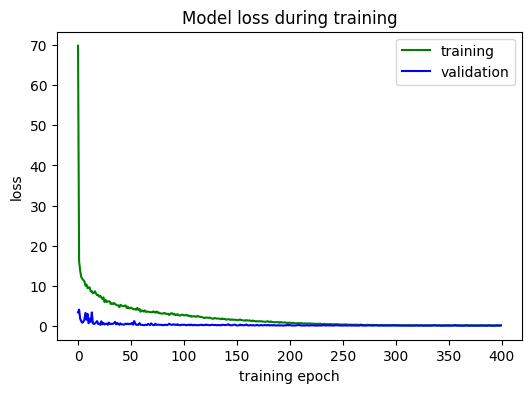

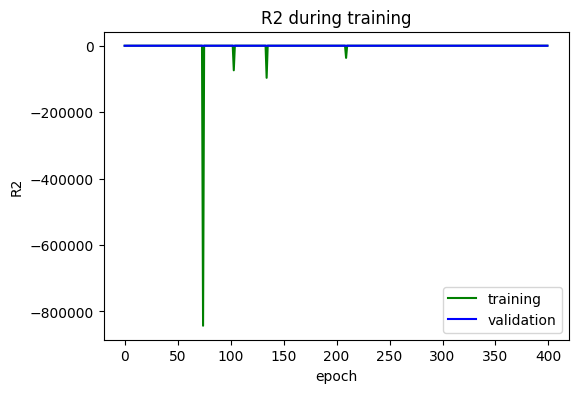

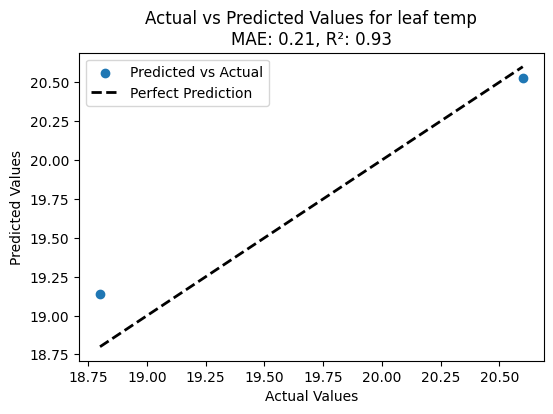

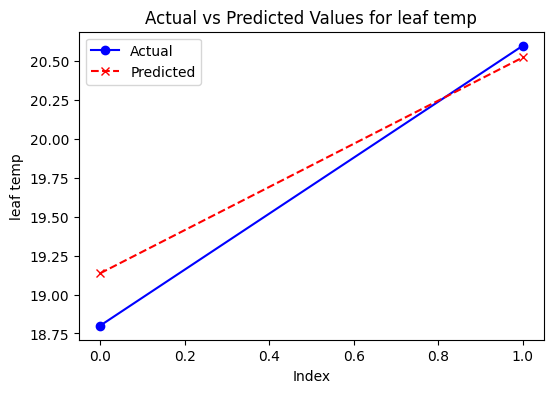

In [12]:
train_and_evaluate_model('leaf temp', flag_train = True, _epochs = 400, _batch_size = 4)

In [ ]:
train_and_evaluate_model('leaf temp', flag_train = False)